<a href="https://colab.research.google.com/github/venkataratnamb20/quicksilicon/blob/notebooks/notebooks/auto/inv_auto_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automate: Inverter


## Setup

### Create directories

In [ ]:
from pathlib import Path

proj_dir = "/content/vb/projects"
proj_dir = Path(proj_dir)
proj_dir.mkdir(parents=True, exist_ok=True)
data_dir = proj_dir / "data"
data_dir.mkdir(parents=True, exist_ok=True)


### cell json file

In [ ]:
%%writefile /content/vb/projects/data/cell.json

{
  "title": "Cell",
  "img": "https://www.elprocus.com/wp-content/uploads/CMOS-Inverter-Symbol-Truth-Table.jpg",
  "tech_params": {
    "nmos": {
      "beta": "3e-4",
      "vth": "400e-3",
      "lambda": "0.2",
      "cgg": "100e-15",
      "cdd": "100e-15"
    },
    "pmos": {
      "beta": "1.5e-4",
      "vth": "500e-3",
      "lambda": "0.2",
      "cgg": "100e-15",
      "cdd": "100e-15"
    }
  },
  "parameters": {
    "length": "0.2",
    "width": {
      "start": "0.2",
      "end": "10",
      "step": "0.1"
    }
  }
}

Writing /content/vb/projects/data/cell.json


### Read json file

In [ ]:
# read json file
import json
import os

from IPython.display import display

def read_json(file_path: os.PathLike):
    """Read JSON File

    Args:
        file_path (os.PathLike): Path to JSON file

    Returns:
        dict: JSON data

    Raises:
        FileNotFoundError: If file not found
        JSONDecodeError: If file is not a valid JSON file
        TypeError: If file is not a valid JSON file
        ValueError: If file is not a valid JSON file
        KeyError: If file is not a valid JSON file
        IndexError: If file is not a valid JSON file
        AttributeError: If file is not a valid JSON file
        NameError: If file is not a valid JSON file
        SyntaxError: If file is not a valid JSON file

    Examples:
        >>> read_json("/content/vb/projects/data/cell.json")
        {'title': 'Cell',
         'img': 'https://www.elprocus.com/wp-content/uploads/CMOS-Inverter-Symbol-Truth-Table.jpg',
         'tech_params': {'nmos': {'beta': '3e-4',
                                  'vth': '400e-3',
                                  'lambda': '0.2',
                                  'cgg': '100e-15',
                                  'cdd': '100e-15'},


    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    if not os.path.isfile(file_path):
        raise TypeError(f"File is not a valid JSON file: {file_path}")

    if not str(file_path).endswith(".json"):
        raise TypeError(f"File is not a valid JSON file: {file_path}")
        # raise ValueError(f"File is not a valid JSON file: {file_path}")

    with open(file_path, "r") as f:
        data = json.load(f)
    return data

if __name__ == "__main__":
    cell = read_json("/content/vb/projects/data/cell.json")
    display(cell)


{'title': 'Cell',
 'img': 'https://www.elprocus.com/wp-content/uploads/CMOS-Inverter-Symbol-Truth-Table.jpg',
 'tech_params': {'nmos': {'beta': '3e-4',
   'vth': '400e-3',
   'lambda': '0.2',
   'cgg': '100e-15',
   'cdd': '100e-15'},
  'pmos': {'beta': '1.5e-4',
   'vth': '500e-3',
   'lambda': '0.2',
   'cgg': '100e-15',
   'cdd': '100e-15'}},
 'parameters': {'length': '0.2',
  'width': {'start': '0.2', 'end': '10', 'step': '0.1'}}}

In [ ]:
cell["tech_params"]["nmos"]

{'beta': '3e-4',
 'vth': '400e-3',
 'lambda': '0.2',
 'cgg': '100e-15',
 'cdd': '100e-15'}

### Calculations

In [ ]:
def get_time_constant(res: float, cap: float) -> float:
    """Get time constant

    Args:
        res (float): Resistance
        cap (float): Capacitance

    Returns:
        float: Time constant
    """
    return res * cap

def get_rise_tc(length: float, width: float) -> float:
    """Get rise time

    Args:
        length (float): Length of cell
        width (float): Width of cell

    Returns:
        float: Rise time
    """
    _nmos_unit_size = 0.4
    _pmos_unit_size = 0.8
    _upcap = width / _nmos_unit_size
    _downcap = length / _pmos_unit_size
    _rise_time = _upcap + _downcap
    return _rise_time



## RC Filter

<p align="center">
    <img src="https://www.electronics-tutorials.ws/wp-content/uploads/2018/05/rc-rc2.gif" width="50%" height="50%" alt="RC Transient Response"/>
</p>



Transient response of a system.

$$Vout = Vin*(1 - e^{-\frac{t}{\tau}})$$


**Terminology**

- `C`: Capacitance
- `R`: Resistance
- `V`: Voltage across Capacitor
- `E`: Energy consumed by the RC Circuit

**Equations**

$$ Time\ Constant (τ) = Resistance * capacitance $$
$$ Delay\ Time (t_d) = 0.69 * \tau $$
$$ Rise\ Time (t_r) = 0.22 * \tau $$
$$ Fall\ Time (t_f) = 0.22 * \tau $$
$$ Settling\ Time (t_{settling\_99p3}) = 5 * \tau $$
$$ bandwidth (f_{3db}) = \frac{1}{2\pi*RC} $$
$$ Energy Consumed (E) = \frac{1}{2}CV^2 $$

In [2]:
from dataclasses import dataclass

@dataclass
class RcCircuit:
    """RcCircuit

    """
    res: float = 1.0
    cap: float = 1e-15
    settling_accuracy: float = 99.3

    def __post_init__(self):
        self._time_constant = self.get_time_constant(self.res, self.cap)
        # trise/tfall = 0.22Tau  for 20% to 80%
        # trise/tfall = 0.35Tau  for 10% to 90%
        self._rise_time = 0.22 * self.time_constant
        self._fall_time = 0.22 * self.time_constant
        self._delay_time = 0.69 * self.time_constant
        # settling time = 3Tau for 95.0% accuracy
        # settling time = 4Tau for 98.2% accuracy
        # settling time = 5Tau for 99.3% accuracy
        self._settling_time = self.get_settling_time(self.res, self.cap, accuracy=self.settling_accuracy)
        self._energy = self.get_energy(self.res, self.cap)

    @property
    def time_constant(self) -> float:
        """Time constant

        Returns:
            float: Time constant
        """
        return self._time_constant

    @property
    def rise_time(self) -> float:
        """Rise time

        Returns:
            float: Rise time
        """
        return self._rise_time

    @property
    def fall_time(self) -> float:
        """Fall time

        Returns:
            float: Fall time
        """
        return self._fall_time

    @property
    def delay_time(self) -> float:
        """Delay time

        Returns:
            float: Delay time
        """
        return self._delay_time

    @property
    def settling_time(self) -> float:
        """Settling time

        accuracy = 99.3% => settling_time = 5 * time_constant


        Returns:
            float: Settling time
        """
        return self._settling_time

    @property
    def f3db(self):
        return 1 / self.time_constant

    @property
    def energy(self) -> float:
        """Energy

        Returns:
            float: Energy
        """
        return self._energy

    @staticmethod
    def get_time_constant(res: float, cap: float) -> float:
        """Get time constant

        Args:
            res (float): Resistance
            cap (float): Capacitance

        Returns:
            float: Time constant
        """
        return res * cap

    @staticmethod
    def get_settling_time(res: float, cap: float, accuracy: float = 99.3) -> float:
        """Get energy

        tsettling = 5 * tau for 99.3% accuracy
        tsettling = 4 * tau for 98.2% accuracy
        tsettling = 3 * tau for 95.0% accuracy

        Args:
            res (float): Resistance
            cap (float): Capacitance
            accuracy (float, optional): Accuracy. Defaults to 99.3.

        Returns:
            float: Energy

        Examples:
            >>
        """
        if accuracy <= 95.0:
            return 3 * RcCircuit.get_time_constant(res, cap)
        elif accuracy <= 98.2:
            return 4 * RcCircuit.get_time_constant(res, cap)
        else:
            return 5 * RcCircuit.get_time_constant(res, cap)

    @staticmethod
    def get_energy(voltage: float, cap: float) -> float:
        """Get energy

        Args:
            voltage (float): voltage across capacitor
            cap (float): Capacitance

        Returns:
            float: Energy
        """
        return 0.5 * cap * (voltage ** 2)


if __name__ == "__main__":
    rcfilt = RcCircuit(res=1e6, cap=1e-15)
    print(f"Time Constant: {rcfilt.time_constant}")
    print(f"rise time: {rcfilt.rise_time}")
    print(f"fall time: {rcfilt.fall_time}")
    print(f"delay time: {rcfilt.delay_time}")
    print(f"settling time: {rcfilt.settling_time}")
    print(f"f3db: {rcfilt.f3db}")
    print(f"energy: {rcfilt.energy}")


Time Constant: 1e-09
rise time: 2.2000000000000002e-10
fall time: 2.2000000000000002e-10
delay time: 6.9e-10
settling time: 5e-09
f3db: 999999999.9999999
energy: 0.0005


### Transient Response

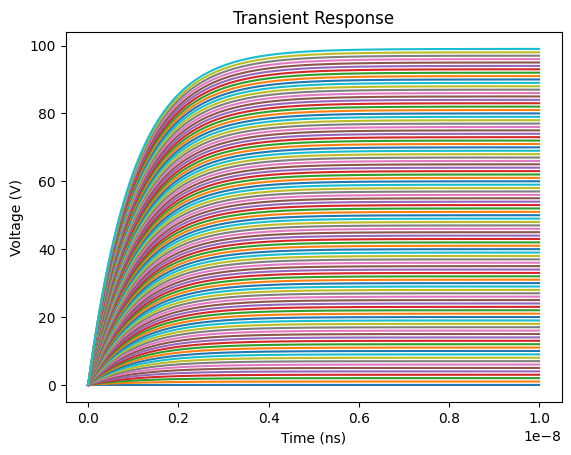

In [10]:
import numpy as np
import matplotlib.pyplot as plt


timescale = 0.001e-9 # ns

def tran_response(time_constant: float, vin: float) -> np.array:
    """Transient response

    Args:
        time_constant (float): Time constant
        voltage (float): Voltage across capacitor

    Returns:
        float: Transient response
    """
    xtime = np.arange(0, 10 * rcfilt.time_constant, timescale)
    # vin = np.ones_like(xtime)
    # transient response
    vout = vin * (1 - np.exp(-xtime / rcfilt.time_constant))
    return xtime, vout


vin = np.array(np.arange(100))
# vin = 10
# xtime, vout = tran_response(rcfilt.time_constant, vin)

# vecres = np.vectorize(tran_response)
for x in vin:
    xtime, vout = tran_response(rcfilt.time_constant, x)

    plt.plot(xtime, vout)
    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (V)")
    plt.title("Transient Response")
plt.show()


In [11]:
xtime.size

10000

### UI

Design User Interface- Guidelines

1. Create sliders for resistance (res) and Capacitance(cap).
2. display all calcalations.
3. Display all values in Engineering format.

## Inverter

**Equations**

$$ V_{od} = V_{GS} - V_{TH} $$
$$ ron = \frac{1}{β\frac{W_p}{L_p}V_{od}} $$
$$ C_{total} = C_{ddp} + C_{ddn} + C_{load} $$

### Inverter: Schematic

### Inverter: Symbol

### Inverter: Testbench

## UI: panel

configure

In [ ]:
import panel as pn

pn.extension("plotly",
             design="material",
             sizing_mode="stretch_width")

pn.config.css_files = ["https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css"]

pn.config.js_files = {
    "bootstrap": "https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"
}



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import plotly.express as px
import plotly.graph_objects as go

pn.extension("plotly", design="material")

_sal = []
def plot_salary(salary):
    _sal.append(salary)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(_sal))), y=_sal))
    # fig.add_trace(go.Scatter(x=[2, 3, 4, 5], y=[6, 8, 10, 12]))
    fig.update_layout(
        title=f"Salary: {salary}",
        xaxis_title="x",
        yaxis_title="y",
    )
    return fig

salary_slider = pn.widgets.FloatSlider(name='Salary', start=0, end=1e6, step=1e3, value=1e4)

pn.Column(salary_slider, pn.bind(plot_salary, salary_slider)).servable()

Column(design=<class 'panel.theme.materi..., sizing_mode='stretch_width')
    [0] FloatSlider(design=<class 'panel.theme.materi..., end=1000000.0, name='Salary', sizing_mode='stretch_width', step=1000.0, value=10000.0)
    [1] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi..., sizing_mode='stretch_width')

# Appendix

## Panel

### Panel: Setup


In [ ]:
!pip install jupyter_bokeh

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
!pip install -U altair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2


### Panel: Styles

1. https://panel.holoviz.org/how_to/styling/apply_css.html


### Bootstrap
```html
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-QWTKZyjpPEjISv5WaRU9OFeRpok6YctnYmDr5pNlyT2bRjXh0JMhjY6hW+ALEwIH" crossorigin="anonymous">

<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js" integrity="sha384-YvpcrYf0tY3lHB60NNkmXc5s9fDVZLESaAA55NDzOxhy9GkcIdslK1eN7N6jIeHz" crossorigin="anonymous"></script>
```


In [ ]:
import panel as pn

# Initialization of panel configuration
pn.extension("plotly",
             design="material",
             sizing_mode="stretch_width")

# bootstrap css settingd
pn.config.css_files = ["https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css"]

# bootstrap js settings
pn.config.js_files = {
    "jquery": "https://cdn.jsdelivr.net/npm/jquery@3.5.1/dist/jquery.slim.min.js",
    "bootstrap": "https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"
}

# dashboard

title = pn.panel("# PySim", align="center", css_classes=["text-primary", "text-center"])

home_link = pn.panel('<a class="" href="https://google.com" target="_blank">Google</a>')
home_btn = pn.panel('<a class="btn btn-secondary" href="https://google.com" target="_blank">Google</a>')
pn.Column(title, home_link, home_btn).servable()

Column(design=<class 'panel.theme.materi..., sizing_mode='stretch_width')
    [0] Markdown(str, align='center', css_classes=['text-primary', ...], design=<class 'panel.theme.materi..., sizing_mode='stretch_width')
    [1] Markdown(str, design=<class 'panel.theme.materi..., sizing_mode='stretch_width')
    [2] Markdown(str, design=<class 'panel.theme.materi..., sizing_mode='stretch_width')

In [ ]:
# dir(pn.config)

### Panel: Plotting

- https://panel.holoviz.org/gallery/altair_brushing.html



In [ ]:
import altair as alt
import pandas as pd
import panel as pn

pn.extension('vega', template='fast')

pn.state.template.title = "Altair Brushing Example"


In [ ]:
df = pd.read_json("https://raw.githubusercontent.com/vega/vega/master/docs/data/penguins.json")

brush = alt.selection_interval(name='brush')  # selection of type "interval"

chart = alt.Chart(df).mark_point().encode(
    x=alt.X('Beak Length (mm):Q', scale=alt.Scale(zero=False)),
    y=alt.Y('Beak Depth (mm):Q', scale=alt.Scale(zero=False)),
    color=alt.condition(brush, 'Species:N', alt.value('lightgray'))
).properties(
    width=300,
    height=300
).add_params(
    brush
)

vega_pane = pn.pane.Vega(chart, debounce=10)

def filtered_table(selection):
    if not selection:
        return df.iloc[:0]
    query = ' & '.join(
        f'{crange[0]:.3f} <= `{col}` <= {crange[1]:.3f}'
        for col, crange in selection.items()
    )
    return df.query(query)

pn.Column(
    'Select points on the plot and watch the linked table update.',
    sizing_mode='stretch_width'
).servable()

pn.Row(
    vega_pane,
    pn.Column(
        pn.pane.DataFrame(
            pn.bind(filtered_table, vega_pane.selection.param.brush)
        ),
        height=350
    )
).servable()


Row(design=<class 'panel.theme.fast.F...)
    [0] Vega(Chart, debounce=10, design=<class 'panel.theme.fast.F..., selection=Selection)
    [1] Column(design=<class 'panel.theme.fast.F..., height=350)
        [0] DataFrame(DataFrame, design=<class 'panel.theme.fast.F...)

In [ ]:
pn.panel(
    """
    <!DOCTYPWE html>
    <html lang="en-US">
    <head>
        <meta charset="utf-8">
        <title>PySim</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css">
        <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"></script>
    </head>
    <body>
        <h1 class="text-center p-4">Hello World</h1>
        <h2 class="my-2">This is a heading2</h2>
        <p>This is a paragraph.</p>
        <h2 class="text-danger">This is a heading2</h2>
        <p>This is a paragraph.</p>
        <p>This is a paragraph.</p>
        <ol>
            <li class="text-info">This is a list item</li>
            <li>This is a list item</li>
            <li>This is a list item</li>
        </ol>
        <p>Unordered list</p>
        <ul>
            <li>This is a list item</li>
            <li>This is a list item</li>
            <li class="bg-danger">This is a list item</li>
        </ul>
        <table>
            <tr>
                <th>Name</th>
                <th>Age</th>
            </tr>
            <tr>
                <td>John</td>
                <td>25</td>
            </tr>
            <tr>
                <td>Jane</td>
                <td>30</td>
            </tr>
        </table>
        <a href="https://www.google.com" target="_blank">Google</a>
    </body>
    </html>
    """
).servable()

Markdown(str, design=<class 'panel.theme.materi..., sizing_mode='stretch_width')